<a href="https://colab.research.google.com/github/konamilk/algorithm-data-structure-practice/blob/main/MLB_lightGBM_forked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training

In [1]:
import sys
from pathlib import Path

In [2]:
# # Install_LightGBM_with_GPU
# if 'google.colab' in sys.modules:
#     ! git clone --recursive https://github.com/Microsoft/LightGBM

#     %cd /content/LightGBM
#     ! mkdir -p build

#     %cd build
#     ! cmake -DUSE_GPU=1 /content/LightGBM
#     ! make -j$(nproc)
#     ! sudo apt-get -y install python-pip
#     ! sudo -H pip install setuptools pandas numpy scipy scikit-learn -U

#     %cd /content/LightGBM/python-package
#     ! sudo python setup.py install --precompile

#     %cd /content/

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
import lightgbm as lgbm
import datetime
import gc
# if 'google.colab' in sys.modules:
#     !pip install git+https://github.com/pfnet-research/xfeat.git > /dev/null
# else:
#     !pip install ../input/xfeatwhl/xfeat-0.1.1-py3-none-any.whl > /dev/null

In [4]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = Path('/content/input/mlb-player-digital-engagement-forecasting')
    TRAIN_DIR = Path('/content/input/mlb-pdef-train-dataset')
    !mkdir output
    OUTPUT_DIR = Path('/content/output')
elif 'kaggle_web_client' in sys.modules:
    BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
    TRAIN_DIR = Path('../input/mlb-pdef-train-dataset')
    OUTPUT_DIR = Path('/kaggle/working')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘output’: File exists


In [5]:
if 'google.colab' in sys.modules:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle
    !chmod 600 ~/.kaggle/kaggle.json
    !pip install kaggle > /dev/null
    !mkdir input
    # original datasets
    !kaggle competitions download -c mlb-player-digital-engagement-forecasting  > /dev/null
    !mkdir input/mlb-player-digital-engagement-forecasting
    !unzip -o '*.zip' -d ./input/mlb-player-digital-engagement-forecasting  > /dev/null
    !mv *.csv ./input/mlb-player-digital-engagement-forecasting
    !rm *.zip
    # MLB_PDEF_train_dataset
    !kaggle datasets download -d columbia2131/mlb-pdef-train-dataset  > /dev/null
    !mkdir input/mlb-pdef-train-dataset
    !unzip -o '*.zip' -d ./input/mlb-pdef-train-dataset  > /dev/null
    !rm *.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘input’: File exists
100% 173k/173k [00:00<00:00, 27.9MB/s]
100% 470M/470M [00:09<00:00, 49.5MB/s]
100% 3.68k/3.68k [00:00<00:00, 3.85MB/s]
100% 824/824 [00:00<00:00, 850kB/s]
100% 3.96M/3.96M [00:00<00:00, 64.4MB/s]
100% 191k/191k [00:00<00:00, 61.3MB/s]
100% 820k/820k [00:00<00:00, 26.2MB/s]
mkdir: cannot create directory ‘input/mlb-player-digital-engagement-forecasting’: File exists

2 archives were successfully processed.
100% 522M/522M [00:12<00:00, 44.2MB/s]
mkdir: cannot create directory ‘input/mlb-pdef-train-dataset’: File exists


In [6]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'DOB']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

standings_cols = ['divisionId', 'teamId', 'streakCode', 'divisionRank', 'leagueRank',
       'wildCardRank', 'leagueGamesBack', 'sportGamesBack',
       'divisionGamesBack', 'wins', 'losses', 'pct', 'runsAllowed',
       #'runsScored',
       'divisionChamp', 'divisionLeader', 'wildCardLeader',
       'eliminationNumber', 'wildCardEliminationNumber', 'homeWins',
       'homeLosses', 'awayWins', 'awayLosses', 'lastTenWins', 'lastTenLosses',
       'extraInningWins', 'extraInningLosses', 'oneRunWins', 'oneRunLosses',
       'dayWins', 'dayLosses', 'nightWins', 'nightLosses', 'grassWins',
       'grassLosses', 'turfWins', 'turfLosses', 'divWins', 'divLosses',
       'alWins', 'alLosses', 'nlWins', 'nlLosses', 'xWinLossPct']

awards_cols = ['awardId', 'playerId']

feature_cols = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
       'isBirthday', 'playerFollowers', 'teamFollowers',

    # from seasons
       'preSeason', 'regularSeason', '1stHalf', '2ndHalf', 'allStar', 'postSeason',

    # from standings
       'divisionId', 'label_streakCode', 'divisionRank', 'leagueRank',
       'wildCardRank', 'leagueGamesBack', 'sportGamesBack',
       'divisionGamesBack', 'wins', 'losses', 'pct', 'runsAllowed',
       'divisionChamp', 'divisionLeader', 'wildCardLeader',
       'eliminationNumber', 'wildCardEliminationNumber', 'homeWins',
       'homeLosses', 'awayWins', 'awayLosses', 'lastTenWins', 'lastTenLosses',
       'extraInningWins', 'extraInningLosses', 'oneRunWins', 'oneRunLosses',
       'dayWins', 'dayLosses', 'nightWins', 'nightLosses', 'grassWins',
       'grassLosses', 'turfWins', 'turfLosses', 'divWins', 'divLosses',
       'alWins', 'alLosses', 'nlWins', 'nlLosses', 'xWinLossPct',
    # from awards
       'label_awardId'
       ]

# feature_cols = ['homeLosses', 'divWins', 'allStar', 'lastTenWins', 'losses',
#        'eliminationNumber', 'regularSeason', 'alWins', 'postSeason',
#        'alLosses', 'errors', 'wildCardEliminationNumber',
#        'saveOpportunities', 'oneRunWins', 'label_primaryPositionName',
#        'assists', 'inningsPitched', '1stHalf', 'chances', 'pitchesThrown',
#        'saves', 'playerFollowers', 'preSeason', 'nightLosses',
#        'extraInningLosses', 'xWinLossPct', 'turfLosses', 'homeWins',
#        'pct', 'dayWins', 'divLosses', 'label_streakCode',
#        'strikeOutsPitching', 'dayLosses', 'label_playerId', '2ndHalf',
#        'divisionId', 'lastTenLosses', 'isBirthday', 'leagueRank',
#        'runsAllowed', 'awayWins', 'grassLosses', 'nightWins', 'hits',
#        'oneRunLosses', 'plateAppearances', 'awayLosses', 'homeRuns',
#        'putOuts', 'leagueGamesBack', 'grassWins', 'gamesStartedPitching',
#        'divisionRank', 'teamFollowers', 'wins', 'nlWins', 'totalBases',
#        'wildCardRank', 'nlLosses', 'battingOrder', 'runsPitching', 'rbi',
#        'divisionGamesBack', 'inheritedRunners', 'turfWins',
#        'label_teamId', 'extraInningWins', 'label_status']

In [7]:
players = pd.read_csv(BASE_DIR / 'players.csv')
rosters = pd.read_pickle(TRAIN_DIR / 'rosters_train.pkl')
targets = pd.read_pickle(TRAIN_DIR / 'nextDayPlayerEngagement_train.pkl')
scores = pd.read_pickle(TRAIN_DIR / 'playerBoxScores_train.pkl')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [8]:
playerFollowers = pd.read_pickle(TRAIN_DIR/'playerTwitterFollowers_train.pkl').drop(['index'], axis=1)
playerFollowers = playerFollowers[playerFollowers['date'] != 20210401]
teamFollowers = pd.read_pickle(TRAIN_DIR/'teamTwitterFollowers_train.pkl').drop(['index'], axis=1)
teamFollowers = teamFollowers[teamFollowers['date'] != 20210401]

In [9]:
seasons = pd.read_csv(BASE_DIR / 'seasons.csv')
for col in seasons.columns:
    if col == 'seasonId':
        continue
    seasons[col] = pd.to_datetime(seasons[col])

In [10]:
standings = pd.read_pickle(TRAIN_DIR / 'standings_train.pkl').drop(['index'], axis=1)
standings['pct'] = standings['pct'].astype(float)
standings['wildCardLeader'] = standings['wildCardLeader'].map(lambda x: x == 'True')
standings['eliminationNumber'] = pd.to_numeric(standings['eliminationNumber'], errors='coerce')
standings['wildCardEliminationNumber'] = pd.to_numeric(standings['wildCardEliminationNumber'], errors='coerce')
standings['divisionRank'] = pd.to_numeric(standings['divisionRank'], errors='coerce')
standings['leagueRank'] = pd.to_numeric(standings['leagueRank'], errors='coerce')
standings['wildCardRank'] = pd.to_numeric(standings['wildCardRank'], errors='coerce')
standings['leagueGamesBack'] = pd.to_numeric(standings['leagueGamesBack'], errors='coerce')
standings['sportGamesBack'] = pd.to_numeric(standings['sportGamesBack'], errors='coerce')
standings['divisionGamesBack'] = pd.to_numeric(standings['divisionGamesBack'], errors='coerce')
standings['divisionChamp'] =  standings['divisionChamp'].map(lambda x: 1 if x else 0)
standings['divisionLeader'] = standings['divisionLeader'].map(lambda x: 1 if x else 0)
standings['wildCardLeader'] = standings['wildCardLeader'].map(lambda x: 1 if x else 0)
standings = standings[standings['date'] < 20210401]

In [12]:
awards = pd.read_pickle(TRAIN_DIR / 'awards_train.pkl').drop('index', axis=1)
awards = awards[awards['date'] < 20210401]

,awardId,awardName,awardDate,awardSeason,playerId,playerName,awardPlayerTeamId,date
0,VWLCPOY,VWL Comeback Player of the Year,2018-01-15,2017,150119,Freddy Garcia,699.0,20180115
1,VWLPOY,VWL Pitcher of the Year,2018-01-15,2017,446861,Guillermo Moscoso,699.0,20180115
2,VWLMOY,VWL Manager of the Year,2018-01-15,2017,492527,Mike Rojas,695.0,20180115
3,VWLRLOY,VWL Reliever of the Year,2018-01-15,2017,519246,Andres Santiago,694.0,20180115
4,VWLOPOY,VWL Offensive Player of the Year,2018-01-15,2017,543874,Jose Vargas,699.0,20180115
...,...,...,...,...,...,...,...,...
5889,CSAS,Caribbean Series All-Star,2021-02-06,2021,477399,Jesse Castillo,1192.0,20210206
5890,CSAS,Caribbean Series All-Star,2021-02-06,2021,501571,Juan Lagares,1191.0,20210206
5891,CSAS,Caribbean Series All-Star,2021-02-06,2021,471822,Jumbo Diaz,1191.0,20210206
5892,CSAS,Caribbean Series All-Star,2021-02-06,2021,466320,Melky Cabrera,1191.0,20210206


In [13]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')

train['_date'] = pd.to_datetime(train['date'].astype(str))
train['year'] = train['_date'].dt.year
train['month'] = train['_date'].dt.month
train['day'] = train['_date'].dt.day
train['dayofweek'] = train['_date'].dt.dayofweek

# merge followers
train['_date_ym'] = train['date'] // 100
playerFollowers['_date_ym'] = playerFollowers['date'] // 100
playerFollowers['playerFollowers'] = playerFollowers['numberOfFollowers']
train = train.merge(playerFollowers[['playerId', '_date_ym', 'playerFollowers']], on=['playerId', '_date_ym'], how='left')
playerFollowers.drop(['_date_ym', 'playerFollowers'], axis=1, inplace=True)

teamFollowers['_date_ym'] = teamFollowers['date'] // 100
teamFollowers['teamFollowers'] = teamFollowers['numberOfFollowers']
train = train.merge(teamFollowers[['teamId', '_date_ym', 'teamFollowers']], on=['teamId', '_date_ym'], how='left')
teamFollowers.drop(['_date_ym', 'teamFollowers'], axis=1, inplace=True)
train.drop('_date_ym', axis=1, inplace=True)

# merge season
train['preSeason'] = False
train['regularSeason'] = False
train['1stHalf'] = False
train['2ndHalf'] = False
train['allStar'] = False
train['postSeason'] = False
for _, row in seasons.iterrows():
    train['preSeason'] = train['preSeason'] | ((row['preSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['preSeasonEndDate']))
    train['regularSeason'] = train['regularSeason'] | ((row['regularSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['regularSeasonEndDate']))
    train['1stHalf'] = train['1stHalf'] | ((row['regularSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['lastDate1stHalf']))
    train['2ndHalf'] = train['2ndHalf'] | ((row['firstDate2ndHalf'] <=  train['_date']) & (train['_date'] <= row['regularSeasonEndDate']))
    train['allStar'] = train['allStar'] | (row['allStarDate'] ==  train['_date'])
    train['postSeason'] = train['postSeason'] | ((row['postSeasonStartDate'] <=  train['_date']) & (train['_date'] <= row['postSeasonEndDate']))

# merge standings
_standings = standings[standings_cols].copy()
_standings['_date'] = pd.to_datetime(standings['date'].astype(str))
train = train.merge(_standings, on=['teamId', '_date'], how='left')
del _standings

# merge awards
_awards = awards[awards_cols].copy()
_awards['_date'] = pd.to_datetime(awards['date'].astype(str))
train = train.merge(_awards, on=['playerId', '_date'], how='left')
del _awards

# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
streakCode2num = {c: i for i, c in enumerate(train['streakCode'].unique())}
awardId2num = {c: i for i, c in enumerate(train['awardId'].unique())}

train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)
train['label_streakCode'] = train['streakCode'].map(streakCode2num)
train['label_awardId'] = train['awardId'].map(awardId2num)


# feature engineering
train['DOB'] = pd.to_datetime(train['DOB'])
train['isBirthday'] = train['date'] % 1000 == train['DOB'].dt.month * 100 + train['DOB'].dt.day

# train.drop('_date', axis=1, inplace=True)

In [14]:
train_X = train[feature_cols]
train_y = train[['target1', 'target2', 'target3', 'target4']]

# _index = (train['date'] < 20210301)
x_train = train_X.loc[train['date'] < 20210301].reset_index(drop=True)
y_train = train_y.loc[train['date'] < 20210301].reset_index(drop=True)
x_valid = train_X.loc[(train['date'] >= 20210301) & (train['date'] < 20210401)].reset_index(drop=True)
y_valid = train_y.loc[(train['date'] >= 20210301) & (train['date'] < 20210401)].reset_index(drop=True)


In [15]:
gc.collect()

163

In [16]:
%%time
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


# training lightgbm
params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 50000,
 'learning_rate': 0.1,
 'random_state': 42,
#  'device': 'gpu',
}

oof1, model1, score1 = fit_lgbm(
    x_train, y_train['target1'],
    x_valid, y_valid['target1'],
    params
)
oof2, model2, score2 = fit_lgbm(
    x_train, y_train['target2'],
    x_valid, y_valid['target2'],
    params
)
oof3, model3, score3 = fit_lgbm(
    x_train, y_train['target3'],
    x_valid, y_valid['target3'],
    params
)
oof4, model4, score4 = fit_lgbm(
    x_train, y_train['target4'],
    x_valid, y_valid['target4'],
    params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.932687
Early stopping, best iteration is:
[70]	valid_0's l1: 0.932675
mae: 0.932675216396163
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2.74404
[200]	valid_0's l1: 2.73599
[300]	valid_0's l1: 2.73146
[400]	valid_0's l1: 2.73415
Early stopping, best iteration is:
[358]	valid_0's l1: 2.72921
mae: 2.729212651596602
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 0.966804
Early stopping, best iteration is:
[45]	valid_0's l1: 0.966445
mae: 0.9664449900812179
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 1.86007
[200]	valid_0's l1: 1.83072
[300]	valid_0's l1: 1.82083
[400]	valid_0's l1: 1.8114
[500]	valid_0's l1: 1.80428
[600]	valid_0's l1: 1.79717
[700]	valid_0's l1: 1.79106
[800]	valid_0's l1: 1.78871
[900]	valid_0's l1: 1.78379
[1000]	valid_0's l1: 1.78139
[1100]	valid_0's l1: 1.78091
[1200]	val

In [17]:
class TestDataset(object):
  def __init__(self, batch_size=5):
    self.current = 0
    self.batch_size = batch_size
    _df = pd.read_csv(BASE_DIR/ 'train.csv')
    self.df_test = _df[_df['date'] >= 20210401]

  def __iter__(self):
    return self

  def __next__(self):
    start = self.current * self.batch_size
    end = (self.current + 1) * self.batch_size
    self.current += 1

    if start >= self.df_test.shape[0]:
      raise StopIteration()

    # df_example_test
    df_example_test = self.df_test[start:end].drop('nextDayPlayerEngagement', axis=1)
    df_example_test.set_index('date', inplace=True)

    # df_example_sample_submission
    df_example_sample_submission = pd.DataFrame()
    for index, row in self.df_test[start:end].iterrows():
        _date = row.date
        _nextDayPlayerEngagement = pd.DataFrame(eval(row.nextDayPlayerEngagement))
        _nextDayPlayerEngagement['date'] = _date
        df_example_sample_submission = pd.concat([df_example_sample_submission, _nextDayPlayerEngagement], axis=0)
    df_example_sample_submission['date_playerId'] = df_example_sample_submission['engagementMetricsDate'].str.replace('-', '') + '_' + df_example_sample_submission['playerId'].astype(str)
    df_example_sample_submission.drop(['engagementMetricsDate', 'playerId'], axis=1, inplace=True)
    df_example_sample_submission.target1 = 0.0
    df_example_sample_submission.target2 = 0.0
    df_example_sample_submission.target3 = 0.0
    df_example_sample_submission.target4 = 0.0
    df_example_sample_submission.set_index('date', inplace=True)
    df_example_sample_submission = df_example_sample_submission[['date_playerId','target1','target2','target3','target4']]
    
    return df_example_test, df_example_sample_submission



In [18]:
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb
    env = mlb.make_env() # initialize the environment
    iter_test = env.iter_test() # iterator which loops over each date in test set
else:
    iter_test = TestDataset()

In [19]:
# null = np.nan
# true = True
# false = False
# test_df, _ = next(iter_test)

In [20]:
# test_df.awards.iloc[3]

In [21]:
players_cols = ['playerId', 'primaryPositionName', 'DOB']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
    sample_prediction_df = sample_prediction_df.reset_index(drop=True)
    
    # creat dataset
    sample_prediction_df['date'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[0]))
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))

    # Dealing with missing values
    if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
        test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
    else:
        test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in rosters.columns:
            if col == 'playerId': continue
            test_rosters[col] = np.nan
            
    if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
        test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
    else:
        test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in scores.columns:
            if col == 'playerId': continue
            test_scores[col] = np.nan
    test_scores = test_scores.groupby('playerId').sum().reset_index()
    test = sample_prediction_df[['playerId', 'date']].copy()
    test = test.merge(players[players_cols], on='playerId', how='left')
    test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
    test = test.merge(test_scores[scores_cols], on='playerId', how='left')

    test['label_playerId'] = test['playerId'].map(player2num)
    test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
    test['label_teamId'] = test['teamId'].map(teamid2num)
    test['label_status'] = test['status'].map(status2num)

    # Update playerFollowers, teamFollowers, standings
    for index, row in test_df.iterrows():
        if row.playerTwitterFollowers == row.playerTwitterFollowers:
            _df = pd.DataFrame(eval(row.playerTwitterFollowers)).copy()
            _df['date'] = pd.to_datetime(_df['date'])
            _df['date'] = _df['date'].map(lambda x: x.year*10000+ x.month * 100 + x.day)
            playerFollowers = pd.concat([playerFollowers, _df],axis=0)
            playerFollowers.reset_index(drop=True)
            del _df

        if row.teamTwitterFollowers == row.teamTwitterFollowers:
            _df = pd.DataFrame(eval(row.teamTwitterFollowers)).copy()
            _df['date'] = pd.to_datetime(_df['date'])
            _df['date'] = _df['date'].map(lambda x: x.year*10000+ x.month * 100 + x.day)
            teamFollowers = pd.concat([teamFollowers, _df],axis=0)
            teamFollowers.reset_index(drop=True)
            del _df
        
        if row['standings'] == row['standings']:
            _standings = pd.DataFrame(eval(row['standings'])).copy()
            _standings['date'] = _standings['gameDate'].str.replace('-', '',-1).astype(int)
            _standings['pct'] = _standings['pct'].astype(float)
            _standings['wildCardLeader'] = _standings['wildCardLeader'].map(lambda x: x == 'True')
            _standings['eliminationNumber'] = pd.to_numeric(_standings['eliminationNumber'], errors='coerce')
            _standings['wildCardEliminationNumber'] = pd.to_numeric(_standings['wildCardEliminationNumber'], errors='coerce')
            _standings['divisionRank'] = pd.to_numeric(_standings['divisionRank'], errors='coerce')
            _standings['leagueRank'] = pd.to_numeric(_standings['leagueRank'], errors='coerce')
            _standings['wildCardRank'] = pd.to_numeric(_standings['wildCardRank'], errors='coerce')
            _standings['leagueGamesBack'] = pd.to_numeric(_standings['leagueGamesBack'], errors='coerce')
            _standings['sportGamesBack'] = pd.to_numeric(_standings['sportGamesBack'], errors='coerce')
            _standings['divisionGamesBack'] = pd.to_numeric(_standings['divisionGamesBack'], errors='coerce')
            _standings['divisionChamp'] =  _standings['divisionChamp'].map(lambda x: 1 if x else 0)
            _standings['divisionLeader'] = _standings['divisionLeader'].map(lambda x: 1 if x else 0)
            _standings['wildCardLeader'] = _standings['wildCardLeader'].map(lambda x: 1 if x else 0)
            standings = pd.concat([standings, _standings],axis=0)
            del _standings

        if row['awards'] == row['awards']:
            _awards = pd.DataFrame(eval(row['awards'])).copy()
            _awards['date'] = _awards['awardDate'].str.replace('-', '',-1).astype(int)
            awards = pd.concat([awards, _awards],axis=0)

    test['_date'] = pd.to_datetime(test['date'].astype(str))
    test['year'] = test['_date'].dt.year
    test['month'] = test['_date'].dt.month
    test['day'] = test['_date'].dt.day
    test['dayofweek'] = test['_date'].dt.dayofweek

    # merge folowers
    test['date_ym'] = test['date'] // 100
    playerFollowers['date_ym'] = playerFollowers['date'] // 100
    playerFollowers['playerFollowers'] = playerFollowers['numberOfFollowers']
    test = test.merge(playerFollowers[['playerId', 'date_ym', 'playerFollowers']], on=['playerId', 'date_ym'], how='left')
    playerFollowers.drop(['date_ym', 'playerFollowers'], axis=1, inplace=True)

    teamFollowers['date_ym'] = teamFollowers['date'] // 100
    teamFollowers['teamFollowers'] = teamFollowers['numberOfFollowers']
    test = test.merge(teamFollowers[['teamId', 'date_ym', 'teamFollowers']], on=['teamId', 'date_ym'], how='left')
    teamFollowers.drop(['date_ym', 'teamFollowers'], axis=1, inplace=True)

    # merge season
    test['preSeason'] = False
    test['regularSeason'] = False
    test['1stHalf'] = False
    test['2ndHalf'] = False
    test['allStar'] = False
    test['postSeason'] = False
    for _, row in seasons.iterrows():
        test['preSeason'] = test['preSeason'] | ((row['preSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['preSeasonEndDate']))
        test['regularSeason'] = test['regularSeason'] | ((row['regularSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['regularSeasonEndDate']))
        test['1stHalf'] = test['1stHalf'] | ((row['regularSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['lastDate1stHalf']))
        test['2ndHalf'] = test['2ndHalf'] | ((row['firstDate2ndHalf'] <=  test['_date']) & (test['_date'] <= row['regularSeasonEndDate']))
        test['allStar'] = test['allStar'] | (row['allStarDate'] ==  test['_date'])
        test['postSeason'] = test['postSeason'] | ((row['postSeasonStartDate'] <=  test['_date']) & (test['_date'] <= row['postSeasonEndDate']))

    # merge standings
    _standings = standings[standings_cols].copy()
    _standings['_date'] = pd.to_datetime(standings['date'].astype(str))
    test = test.merge(_standings, on=['teamId', '_date'], how='left')
    del _standings
    test['label_streakCode'] = test['streakCode'].map(streakCode2num)

    # merge awards
    _awards = awards[awards_cols].copy()
    _awards['_date'] = pd.to_datetime(awards['date'].astype(str))
    _awards.drop_duplicates(subset = ['playerId', '_date'] ,keep='first', inplace=True)
    test = test.merge(_awards, on=['playerId', '_date'], how='left')
    # del _awards
    test['label_awardId'] = test['awardId'].map(awardId2num)



    # drop _date
    test.drop('_date', axis=1, inplace=True)

    # feature engineering
    test['DOB'] = pd.to_datetime(test['DOB'])
    test['isBirthday'] = test['date'] % 1000 == test['DOB'].dt.month * 100 + test['DOB'].dt.day
    
    test_X = test[feature_cols]
    
    # predict
    pred1 = model1.predict(test_X)
    pred2 = model2.predict(test_X)
    pred3 = model3.predict(test_X)
    pred4 = model4.predict(test_X)
    
    # merge submission
    sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
    sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
    sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
    sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
    sample_prediction_df = sample_prediction_df.fillna(0.)
    sample_prediction_df.drop(['playerId', 'date'], axis=1, inplace=True)
    
    if 'kaggle_secrets' in sys.modules:
        env.predict(sample_prediction_df)
    

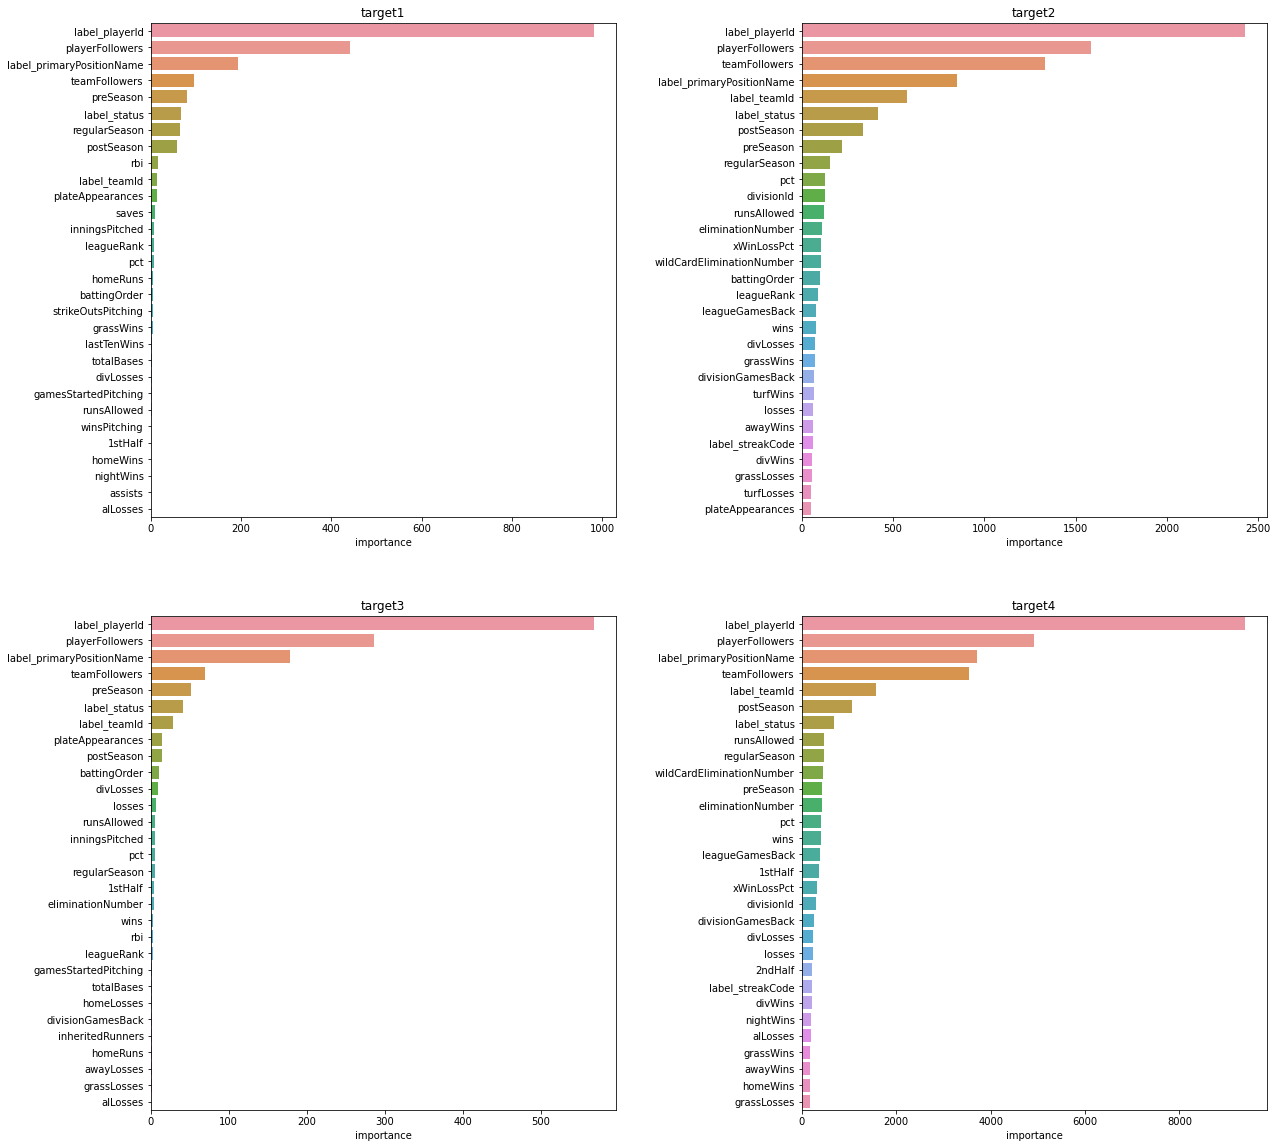

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
models = [model1, model2, model3, model4]

fig, axes = plt.subplots(2, 2, figsize=(20,20))
plt.subplots_adjust(wspace=0.4)
for i, model in enumerate(models):
    
    data = pd.DataFrame({'importance': model.feature_importances_, 'feature': feature_cols}).sort_values('importance', ascending = False)[0:30]

    ax = axes[ i // 2, i % 2]
    ax.yaxis.label.set_visible(False)
    ax.set_title('target' + str(i+1))
    
    sns.barplot(x='importance', y='feature', data=data, ax=ax)

plt.savefig(OUTPUT_DIR / 'feature_importance.png')


In [28]:
# top50 importances
top_features = []
for i, model in enumerate(models):
    data = pd.DataFrame({'importance': model.feature_importances_, 'feature': feature_cols}).sort_values('importance', ascending = False)[0:50]
    top_features += data.feature.to_list()
top_features = list(set(top_features))
np.array(top_features)

array(['atBats', 'intentionalWalks', 'awayLosses', 'divisionLeader',
       'label_awardId', 'turfWins', 'nlWins', 'preSeason', 'divisionId',
       'nlLosses', 'baseOnBalls', 'xWinLossPct', 'homeRuns', 'homeWins',
       'strikeOutsPitching', '1stHalf', 'label_streakCode',
       'wildCardRank', 'homeLosses', 'leagueGamesBack', 'alWins',
       'lastTenWins', 'postSeason', 'divWins', 'runsAllowed',
       'hitByPitch', 'extraInningLosses', 'playerFollowers', 'grassWins',
       'alLosses', 'assists', 'leftOnBase', 'turfLosses',
       'wildCardEliminationNumber', 'divisionGamesBack', 'oneRunLosses',
       'saves', 'allStar', 'divisionChamp', 'nightLosses', 'wins',
       'totalBases', 'eliminationNumber', 'losses', 'regularSeason',
       'label_primaryPositionName', 'dayWins', 'dayLosses', 'oneRunWins',
       'extraInningWins', 'stolenBases', '2ndHalf', 'plateAppearances',
       'nightWins', 'grassLosses', 'sportGamesBack', 'label_playerId',
       'awayWins', 'caughtStealing', 'h

In [29]:
len(top_features)

79

In [31]:
# 0/0

# save mlflow

In [32]:
if 'google.colab' in sys.modules:
    import os

    try:
        from google.colab import auth
        auth.authenticate_user()
    except ImportError:
        pass

    REPOSITORY_NAME = 'kaggleops-tutorial'
    PROJECT_ID = 'mlb-project-317407'
    BUCKET_NAME = 'mlb-bucket'

    os.environ["GCLOUD_PROJECT"] = PROJECT_ID

    from google.cloud import storage
    storage_client = storage.Client(project=PROJECT_ID)
    !rm -rf {REPOSITORY_NAME}
    !git clone https://github.com/yuooka/{REPOSITORY_NAME}.git
    !pip install -qr ./{REPOSITORY_NAME}/requirements.txt
    # cd ./{REPOSITORY_NAME}/src
    !gcloud config set project {PROJECT_ID}
    # !gsutil -mq cp -rn gs://{BUCKET_NAME}/mlruns /content/{BUCKET_NAME}/src

    blobs = storage_client.list_blobs(BUCKET_NAME)
    for blob in blobs:
        filepath = blob.name
        if filepath[:7]=="mlruns/" and len(filepath)!=7:
            os.makedirs("/".join(filepath.split("/")[:-1]), exist_ok=True)
            blob.download_to_filename(filepath)

Cloning into 'kaggleops-tutorial'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 69 (delta 22), reused 59 (delta 12), pack-reused 0
Unpacking objects: 100% (69/69), done.
     |████████████████████████████████| 12.0MB 3.8MB/s 
     |████████████████████████████████| 573kB 38.5MB/s 
     |████████████████████████████████| 6.0MB 30.8MB/s 
     |████████████████████████████████| 348kB 41.9MB/s 
     |████████████████████████████████| 153kB 53.4MB/s 
     |████████████████████████████████| 174kB 50.9MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 81kB 1.5MB/s 
     |████████████████████████████████| 174kB 35.6MB/s 
     |████████████████████████████████| 5.6MB 18.7MB/s 
     |████████████████████████████████| 901kB 50.4MB/s 
     |████████████████████████████████| 133kB 51.4MB/s 
     |████████████████████████████████| 1.2MB 30.8MB/s 
 

In [33]:
if 'google.colab' in sys.modules:
    import mlflow
    mlflow.start_run()
    mlflow.log_param("feature_cols", feature_cols)
    mlflow.log_param("params", params)
    mlflow.log_param("top_features", top_features)
    mlflow.log_metric('score', score)
    mlflow.log_metric('score1', score1)
    mlflow.log_metric('score2', score2)
    mlflow.log_metric('score3', score3)
    mlflow.log_metric('score4', score4)
    for i, model in enumerate(models):
        mlflow.log_param('feature_importance_' + str(i+1), model.feature_importances_)
    mlflow.log_artifact(OUTPUT_DIR / 'feature_importance.png')
    mlflow.end_run()

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):


In [34]:
if 'google.colab' in sys.modules:
    !python ./{REPOSITORY_NAME}/src/mlproject.py
    # !gsutil -mq cp -rn /content/{REPOSITORY_NAME}/src/mlruns gs://{BUCKET_NAME}

    import glob

    files = [f for f in glob.glob("mlruns/**", recursive=True) if f[:7]=="mlruns/" and len(f)!=7]
    files_in_bucket = [f.name for f in storage_client.list_blobs(BUCKET_NAME)]
    bucket = storage_client.get_bucket(BUCKET_NAME)

    for f in files:
        try:
            if f not in files_in_bucket:
                blob = bucket.blob(f)
                blob.upload_from_filename(f)
        except:
            pass

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
Traceback (most recent call last):
  File "./kaggleops-tutorial/src/mlproject.py", line 17, in <module>
    exp_id = client.create_experiment(config['experiment_name'], artifact_location=f"gs://{config['bucket_name']}/artifacts")
  File "/usr/local/lib/python3.7/dist-packages/mlflow/tracking/client.py", line 161, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location)
  File "/usr/local/lib/python3.7/dist-packages/mlflow/tracking/_tracking_service/client.py", line 128, in create_experiment
    artifact_location=artifact_location,
  File "/usr/local/lib/python3.7/dist-packages/mlflow/store/tracking/file_store.py", line 239, in create_experiment
    self._validate_experiment_n